<a href="https://colab.research.google.com/github/tech-data/Pytorch-Tutorial/blob/main/transfer_learning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
!unzip /content/drive/MyDrive/data.zip -d data


In [ ]:
!pip install split-folders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

splitfolders.ratio('data', output="output", seed=1337, ratio=(.8, 0.2)) 


Copying files: 11742 files [00:01, 6389.81 files/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


train_dir = 'output/train'
test_dir = 'output/val'

Train = datasets.ImageFolder(train_dir,data_transforms)
Test = datasets.ImageFolder(test_dir,test_transforms)

trainloader = torch.utils.data.DataLoader(Train, batch_size=4,
                                             shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(Test, batch_size=4,
                                             shuffle=True, num_workers=4)
class_names = Train.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


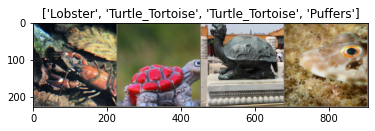

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                datasetloader = trainloader
                dataset_sizes = len(Train)
            else:
                model.eval()   # Set model to evaluate mode
                datasetloader = testloader
                dataset_sizes = len(Test)

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            
            for inputs, labels in datasetloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 19.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 19)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a





In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7432 Acc: 0.7826
val Loss: 0.6229 Acc: 0.8450

Epoch 1/24
----------
train Loss: 0.7312 Acc: 0.7863
val Loss: 0.6388 Acc: 0.8429

Epoch 2/24
----------
train Loss: 0.6899 Acc: 0.7973
val Loss: 0.6138 Acc: 0.8463

Epoch 3/24
----------
train Loss: 0.7104 Acc: 0.7914
val Loss: 0.6251 Acc: 0.8429

Epoch 4/24
----------
train Loss: 0.7140 Acc: 0.7919
val Loss: 0.6110 Acc: 0.8437

Epoch 5/24
----------
train Loss: 0.7230 Acc: 0.7875
val Loss: 0.6133 Acc: 0.8488

Epoch 6/24
----------
train Loss: 0.7065 Acc: 0.7897
val Loss: 0.6055 Acc: 0.8467

Epoch 7/24
----------
train Loss: 0.7254 Acc: 0.7834
val Loss: 0.5989 Acc: 0.8433

Epoch 8/24
----------
train Loss: 0.7183 Acc: 0.7933
val Loss: 0.6345 Acc: 0.8476

Epoch 9/24
----------
train Loss: 0.7209 Acc: 0.7852
val Loss: 0.6217 Acc: 0.8471

Epoch 10/24
----------
train Loss: 0.7077 Acc: 0.7911
val Loss: 0.6145 Acc: 0.8416

Epoch 11/24
----------
train Loss: 0.7086 Acc: 0.7872
val Loss: 0.5914 Acc: 0.8459

Ep

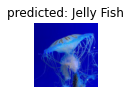

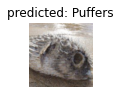

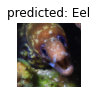

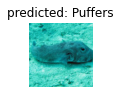

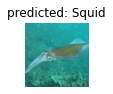

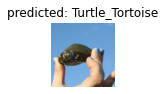

In [ ]:
visualize_model(model_ft)

In [ ]:

from PIL import Image
img = Image.open('Jellyfish.jpeg')
x = test_transforms(img)
x=x.unsqueeze(0).to(device)
print(class_names[torch.argmax(model_ft(x))])


Jelly Fish
